In [5]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext 
from pyspark.sql.functions import explode, split, col, instr
from IPython import display
from time import sleep
import matplotlib.pyplot as plt

In [6]:
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [7]:
tweet_stream = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 6666).load()

In [8]:
# Split tweets into words
tweet_words = tweet_stream.select(explode(split(tweet_stream.value, " ")).alias("word"))
# Filter tweets to those with #
Hashtag_words = tweet_words.where(instr(col("word"),"#")>=1)
# Calculate the count of each Hashtag
Hashtag_wordCount = Hashtag_words.groupBy("word").count()

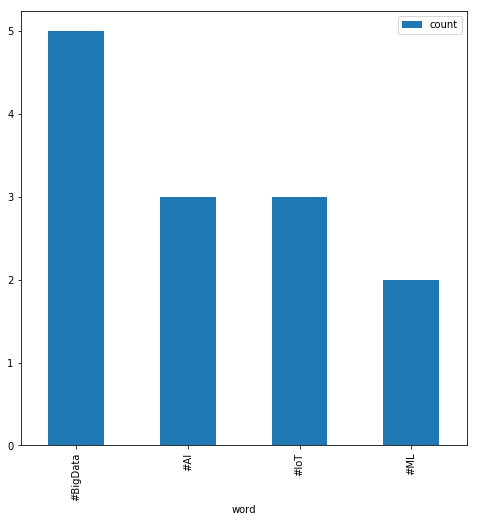

KeyboardInterrupt: 

In [9]:
query = Hashtag_wordCount.writeStream.queryName("df").format("memory").outputMode("complete").start()

itr = 0
while itr < 100:    
    sleep(1)            
    df_hashtag_wordCount = sqlContext.sql("select word, count, ROW_NUMBER() OVER(ORDER BY count DESC) AS RowNumber from df")
    df_top_5_hashtag_tweets = df_hashtag_wordCount.where(col("RowNumber")<5)
    
    if df_top_5_hashtag_tweets.count()>0:        
        
        df_plot = df_top_5_hashtag_tweets.toPandas()
        display.clear_output(wait=True)
        plt.rcParams['figure.figsize'] = (8,8)
        df_plot.plot.bar( x="word", y="count")
        plt.show()
    
    itr = itr + 1

query.awaitTermination()

In [10]:
ssc.stop()